In [77]:
import re, math, requests, numpy as np
from functools import reduce
import nltk.stem.snowball, bs4, collections
from scipy.spatial.distance import cosine

In [78]:
text_urls = [
    "https://en.wikipedia.org/wiki/Philosophy",
    "https://en.wikipedia.org/wiki/Scientist",
    "https://en.wikipedia.org/wiki/Science",
    "https://en.wikipedia.org/wiki/Chemistry",
    "https://en.wikipedia.org/wiki/Physics",
    "https://en.wikipedia.org/wiki/Mathematics",
    "https://en.wikipedia.org/wiki/Poetry",
    "https://en.wikipedia.org/wiki/Prose",
    "https://en.wikipedia.org/wiki/Literature",
    "https://en.wikipedia.org/wiki/Theatre",
    "https://en.wikipedia.org/wiki/Culture",
    "https://en.wikipedia.org/wiki/Novel",
    "https://en.wikipedia.org/wiki/Radio",
    "https://en.wikipedia.org/wiki/Mythology",
    "https://en.wikipedia.org/wiki/Spiritism",
    "http://www.yourdictionary.com/philosophy",   
]
# download htmls texts. Better use this cell once - it will take some time
htmls = [(url, requests.get(url).text) for url in text_urls]

In [79]:
# BeautifulSoup is used dor xml processing
from bs4 import BeautifulSoup

#regexps to remove script and style parts - as the contain CODE (not english language)
scripts = re.compile(r'<script.*?</style>')
css = re.compile(r'<style.*?/style>')

texts = dict()
for u, t in htmls:
    # remove code
    t = scripts.sub('', t)
    t = css.sub('', t)
    # remove [...] {...} (...)
    t = re.sub('\[.*\]', '', t)
    t = re.sub('\(.*\)', '', t)
    t = re.sub('\{.*\}', '', t)
    t = BeautifulSoup(t, "lxml").text
    texts[u] = t

In [80]:
# split all text to words
# and perform stemming!

def textToWords(text):
    stemmer = nltk.stem.snowball.RussianStemmer()
    return [stemmer.stem(word).lower() for word in re.split('\W+', text) if len(word) > 2 and len(word) < 15]

words = dict((u, textToWords(t)) for (u, t) in texts.items())

sample = list(words.values())[0][300:320]
print(sample)

['natura', 'philosoph', 'mora', 'philosoph', 'metaphysica', 'philosoph', 'this', 'division', 'not', 'obsolet', 'but', 'has', 'changed', 'natura', 'philosoph', 'has', 'split', 'int', 'the', 'various']


In [81]:
# extract all words in our texts and build an ordered list of them - this text is called lexicon
lexiconSet = reduce(lambda s, all: all | s, map(set, words.values()), set())
lexicon = list(lexiconSet)
IDF = [0] * len(lexicon)
print("Lexicon size is", len(lexicon))

def vectorize(bookW, lexicon, IDF=None):
    TF = collections.Counter()
    for word in bookW:
        TF[word] += 1
    vector = [0] * len(lexicon)
    
    for j in range(len(lexicon)):
        vector[j] = TF[lexicon[j]]
        if IDF is not None and vector[j]:
            IDF[j] += 1
    return np.array(vector)

# vector representation of texts is called index
index = dict()
for u, book in words.items():
    vector = vectorize(book, lexicon, IDF)
    index[u] = vector

Lexicon size is 13297


In [82]:
N = len(index)

def norm(wordCount, IDF, Nbooks):
    # first multiplier smoothes wordcount influence
    # second reduces widely used words influence
    # this model is called TF-IDF: https://en.wikipedia.org/wiki/Tf–idf
    return math.log(1 + wordCount, 2) * math.log(Nbooks / IDF, 2)

def normVector(vector, IDF):
    return list(map(lambda v: norm(*v, N), zip(vector, IDF)))

for u, v in index.items():
    v2 = np.array(normVector(v, IDF))
    index[u] = v2


def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def search(query):
    print("Ищем:", query)
    vect = vectorize(textToWords(query), lexicon)
    out = [(cosine(txt, vect), u) for u, txt in index.items()]
    return sorted(out, reverse=True)

print(*search("Marx")[:4], sep="\n")
print(*search("thing about songs and all the staff")[:4], sep="\n")

# similar this you can see done using gensim package:
# https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/gensim%20Quick%20Start.ipynb

Ищем: Marx
(0.023799532375740097, 'https://en.wikipedia.org/wiki/Novel')
(0.018910940085099543, 'https://en.wikipedia.org/wiki/Culture')
(0.015463248279925602, 'https://en.wikipedia.org/wiki/Philosophy')
(0.0, 'https://en.wikipedia.org/wiki/Theatre')
Ищем: thing about songs and all the staff
(0.019463670180253311, 'https://en.wikipedia.org/wiki/Science')
(0.01441114703296029, 'https://en.wikipedia.org/wiki/Literature')
(0.013746317316102994, 'https://en.wikipedia.org/wiki/Theatre')
(0.011631787698968044, 'https://en.wikipedia.org/wiki/Poetry')


In [83]:
# show this database
from sklearn.decomposition import PCA
# we cannot use PCA, but we can still fit the data into planes
labels = list(key[30:] for key in index.keys())
X = [index[key] for key in index]


pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

import math
# this hack applies sigmoida to data, as the data is always centered
X_reduced = [[math.atan2(p[0], 7), math.atan2(p[1], 7)] for p in X_reduced]

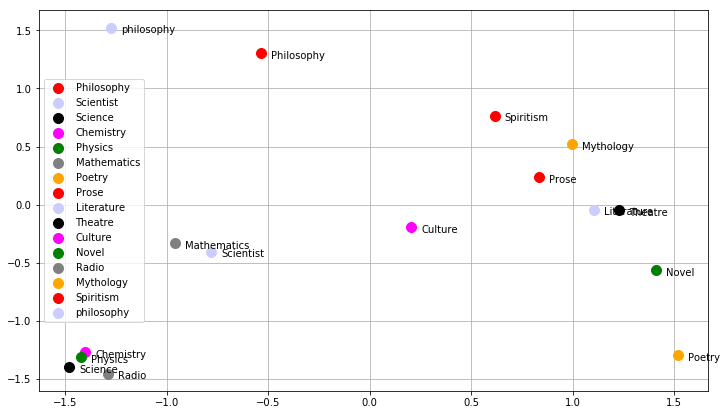

In [84]:
import matplotlib.pyplot as plt
colors = ['red', '#CCCCFF', 'black', 'magenta', 'green', 'gray', 'orange']
colors = colors * 4

plt.figure(figsize=(12,7))
for point, color, label in zip(X_reduced, colors, labels):
    plt.annotate(label, xy=point, xytext=(10, -5), textcoords='offset points')
    plt.plot(*point, 'o', markersize=10,color=color,label=label)
plt.legend()
plt.grid(True)
plt.show()